In [11]:
import pandas as pd
from pandas import DataFrame, Series, NaT
from matplotlib.font_manager import _rebuild
import matplotlib.pyplot as plt
from matplotlib import font_manager

plt.rcParams['font.family']=['Microsoft YaHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False 
from os.path import join
plt.rcParams.update({'font.size':20})
from numpy import infty
import json


def contain_codes(json_str, synyi_codes):
    if pd.isnull(json_str):
        return Series([0]*len(synyi_codes), index=synyi_codes)
    try:
        combined_list = []
        for l in json.loads(json_str):
            combined_list += l

        matches = []
        for synyi_code in synyi_codes:
            if synyi_code in combined_list:
                matches.append(1)
            else:
                matches.append(0)
        return Series(matches, index=synyi_codes)
    except:
        return Series([0]*len(synyi_codes), index=synyi_codes)        
    

def any_contain(strs, target):
    result = False
    for str_ in strs:
        if target in str_:
            result = True
            break

    return result


def contain_drug(s, drugs, columns):
    parsed = json.loads(s)
    if len(parsed) > 1:
        js = parsed[0]
        drug_parsed = json.loads(js)
        
        result = []
        for drug in drugs:
            if any_contain(drug_parsed, drug):
                result.append(1)
            else:
                result.append(0)        
    else:
        result = [0]*len(drugs)

    return Series(result, columns)

def attach_splitted_drug(df, drugs):
    columns = ['抗凝药物_{}'.format(drug) for drug in drugs]
    
    df[columns] = df['长期抗凝'].apply(lambda s: contain_drug(s, drugs, columns))
    
    return df


def attach_split(df, columns, synyi_codes, target, tag):
    synyi_codes = [str(i) for i in synyi_codes]
    columns = ['{}_{}'.format(tag, c) for c in columns]
    df[columns] = df[target].apply(lambda s:contain_codes(s, synyi_codes))
    
    return df

def attach_ecg_result(df, target, target_code):
    df['ecg_yes_找到146631'] = df[target].apply(lambda s:target_code in json.loads(s) if pd.notnull(s) else False)
    return df


def get_event_span(df, event_cols, min_visit_time, span, event_name):
    condition = Series(False, index=df.index)
    for event_col in event_cols:
        condition = condition | (df[event_col] == 1)
    event_time = df.loc[condition, 'visit_time']
    
    if len(event_time) > 0:
        first_event_time = event_time.min()
    else:
        first_event_time = None
        
    if (min_visit_time is not None) and (first_event_time is not None):
        first_span = (first_event_time - min_visit_time).days
    else:
        first_span = None
        
    if (first_span is not None) and (span is not None):
        progress = (first_span + 1) / (span + 1)
    else:
        progress = None    
        
    return Series([first_span, progress], index=['首次发生{}跨度（天）'.format(event_name), '首次发生{}跨度占比'.format(event_name)])


def get_event(df, configs):
    for event_name, target_cols in configs:
        condition = Series(False, index=df.index)
        for target_col in target_cols:
            condition = (condition | df[target_col] == 1)
        df[event_name] = condition
        
    return df
    

def extract_first_event_time(df, target_col, time_col):
    try:
        first_event_index = list(df[target_col]).index(1)
        return df[time_col].iat[first_event_index]
    except ValueError:
        return NaT
        
    
def extract_patient_first_event(df):
    event_config = [
        ('房颤', ['synyi诊断_房颤']),
        ('卒中', ['synyi诊断_ 卒中（脑血管意外）', 'synyi诊断_出血性卒中']),
        ('脑梗', ['synyi诊断_大脑梗塞'])
    ]
    
    
    df = get_event(df, event_config)
    
    first_event_times = []
    for col in ['房颤', '卒中', '脑梗']:
        first_event_times.append(extract_first_event_time(df, col, 'visit_time'))
    first_event_s = Series(first_event_times, index=['房颤', '卒中', '脑梗'], dtype='datetime64[ns]')
    
    return first_event_s

    
def extract_patient_level(df):
    df = df.sort_values('visit_time')
    
    min_visit_time = df['visit_time'].min()
    max_visit_time = df['visit_time'].max()    
    
    if (min_visit_time is not None) and (max_visit_time is not None):
        span = (max_visit_time - min_visit_time).days
    else:
        span = None
        
    event_config = [
        ('房颤', ['synyi诊断_房颤']),
        ('卒中', ['synyi诊断_ 卒中（脑血管意外）', 'synyi诊断_出血性卒中']),
        ('脑梗', ['synyi诊断_大脑梗塞'])
    ]
    

    df = get_event(df, event_config)    
        
    s_list = []
    for event_name, event_cols in event_config:
        s = get_event_span(df, event_cols, min_visit_time, span, event_name)
        s_list.append(s)
    event_series = pd.concat(s_list)

    diags = ['synyi诊断_出血', 'synyi诊断_房颤', 'synyi诊断_阵发/非阵发', 'synyi诊断_高血压',
       'synyi诊断_糖尿病', 'synyi诊断_心衰', 'synyi诊断_缺血性中风', 'synyi诊断_ 卒中（脑血管意外）',
       'synyi诊断_出血性卒中', 'synyi诊断_大脑梗塞', 'synyi诊断_死亡', 'ecg_yes_找到146631']

    drugs = ['抗凝药物_阿司匹林', '抗凝药物_肝素', '抗凝药物_华法林', '抗凝药物_倍他洛克', '抗凝药物_达比加群酯',
       '抗凝药物_利伐沙班']
    
    
    count_sum = df[diags + drugs].sum()
    basic = Series([min_visit_time, max_visit_time, span], index=['首次就诊时间', '末次就诊时间','跨度（天）'])
    
    return pd.concat([basic, count_sum, event_series])

In [2]:
df = (
    pd.read_table('diag_fangchan_01.csv', encoding='gb18030', sep=',')
    .drop(['ECG源'], axis=1)
    .drop_duplicates(['visit_id'])
)

df_time = pd.read_csv('visit_time.csv', parse_dates=['visit_time'])

df = df.merge(df_time, on='visit_id',how='left')


df = attach_ecg_result(df, 'ecg_nlp_yes', '146631')

columns = ['出血', '房颤', '阵发/非阵发', '高血压', '糖尿病', '心衰', '缺血性中风',' 卒中（脑血管意外）','出血性卒中','大脑梗塞','死亡']
synyi_codes = [75280, 85267, 122912, 91965, 71967, 75574, 83964, 86561, 74871, 76025, 76998]
df = attach_split(df, columns, synyi_codes, '诊断synyi码', 'synyi诊断')


drug_names = [
    '阿司匹林',
    '肝素',
    '华法林',
    '倍他洛克',
    '达比加群酯',
    '利伐沙班'    
]
df = attach_splitted_drug(df, drug_names)

# print('saving')
# df.to_excel('visit_df.xlsx')

In [3]:
patient_first_event_df = df.groupby('pat_id').apply(extract_patient_first_event).astype('datetime64[ns]')

In [4]:
patient_df = df.groupby('pat_id').apply(extract_patient_level)
patient_df = patient_df.join(patient_first_event_df)

In [5]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

0    0.5
dtype: float64
0    0.5
dtype: float64


Text(0.5,0,'天数/365天')

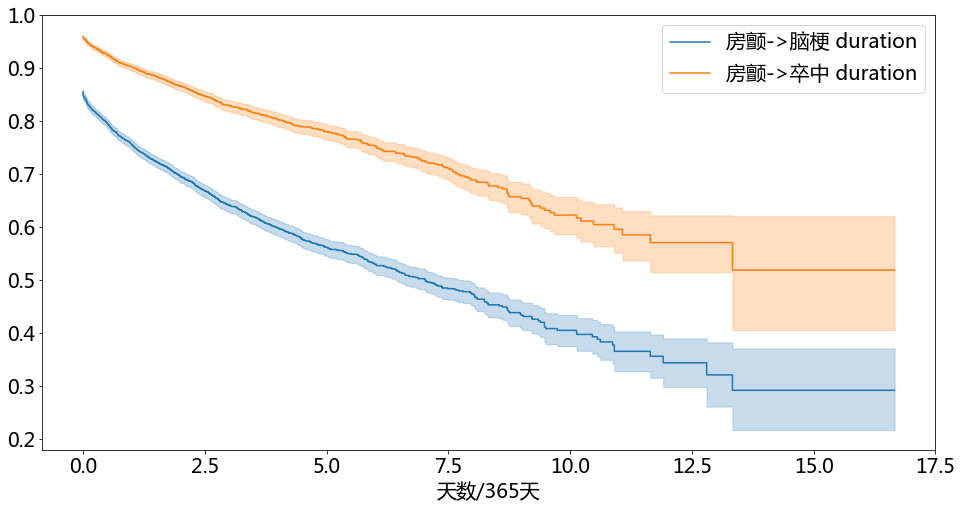

In [27]:
event_pairs = [
    ('房颤', '脑梗'),
    ('房颤', '卒中'), 
#     ('首次就诊时间','脑梗'),     
]

fig, ax = plt.subplots(figsize=[16, 8])

events = ['房颤', '脑梗', '卒中']
for event in events:
    patient_df['观察到{}'.format(event)] = patient_df[event].notnull()

for start_event, end_event in event_pairs:
    patient_df['{}-{} duration'.format(end_event, start_event)] = ((patient_df[end_event].combine(
        patient_df['末次就诊时间'],
        lambda x1, x2: x2 if pd.isnull(x1) else x1
    ) - patient_df[start_event])).dt.total_seconds()/(24 * 3600 * 365)
    
    sub_patient_df = patient_df.loc[patient_df[start_event].notnull() & (patient_df['{}-{} duration'.format(end_event, start_event)] >=0)]
    T = sub_patient_df['{}-{} duration'.format(end_event, start_event)]
    E = sub_patient_df['观察到{}'.format(end_event)]

    kmf.fit(T, event_observed=E, label='{}->{} duration'.format(start_event, end_event))   
    kmf.plot(ax=ax)
#     plt.title('{}-{} duration'.format(end_event, start_event))
ax.set_xlabel('天数/365天')    
    
    

In [28]:
output = 'result'

In [29]:
list(patient_df.columns)

['首次就诊时间',
 '末次就诊时间',
 '跨度（天）',
 'synyi诊断_出血',
 'synyi诊断_房颤',
 'synyi诊断_阵发/非阵发',
 'synyi诊断_高血压',
 'synyi诊断_糖尿病',
 'synyi诊断_心衰',
 'synyi诊断_缺血性中风',
 'synyi诊断_ 卒中（脑血管意外）',
 'synyi诊断_出血性卒中',
 'synyi诊断_大脑梗塞',
 'synyi诊断_死亡',
 'ecg_yes_找到146631',
 '抗凝药物_阿司匹林',
 '抗凝药物_肝素',
 '抗凝药物_华法林',
 '抗凝药物_倍他洛克',
 '抗凝药物_达比加群酯',
 '抗凝药物_利伐沙班',
 '首次发生房颤跨度（天）',
 '首次发生房颤跨度占比',
 '首次发生卒中跨度（天）',
 '首次发生卒中跨度占比',
 '首次发生脑梗跨度（天）',
 '首次发生脑梗跨度占比',
 '房颤',
 '卒中',
 '脑梗',
 '观察到房颤',
 '观察到脑梗',
 '观察到卒中',
 '脑梗-房颤 duration',
 '卒中-房颤 duration',
 '脑梗-首次就诊时间 duration']

In [30]:
columns = [
'跨度（天）',
 'synyi诊断_出血',
 'synyi诊断_房颤',
 'synyi诊断_阵发/非阵发',
 'synyi诊断_高血压',
 'synyi诊断_糖尿病',
 'synyi诊断_心衰',
 'synyi诊断_缺血性中风',
 'synyi诊断_ 卒中（脑血管意外）',
 'synyi诊断_出血性卒中',
 'synyi诊断_大脑梗塞',
 'synyi诊断_死亡',
 'ecg_yes_找到146631',
 '抗凝药物_阿司匹林',
 '抗凝药物_肝素',
 '抗凝药物_华法林',
 '抗凝药物_倍他洛克',
 '抗凝药物_达比加群酯',
 '抗凝药物_利伐沙班',
 '首次发生房颤跨度（天）',
 '首次发生房颤跨度占比',
 '首次发生卒中跨度（天）',
 '首次发生卒中跨度占比',
 '首次发生脑梗跨度（天）',
 '首次发生脑梗跨度占比',
 '房颤',
 '卒中',
 '脑梗',
 '观察到房颤',
 '观察到脑梗',
 '观察到卒中',
 '脑梗-房颤 duration',
 '卒中-房颤 duration',
 '脑梗-首次就诊时间 duration'
]
patient_df = patient_df[columns]

In [31]:
from numpy import infty

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memo

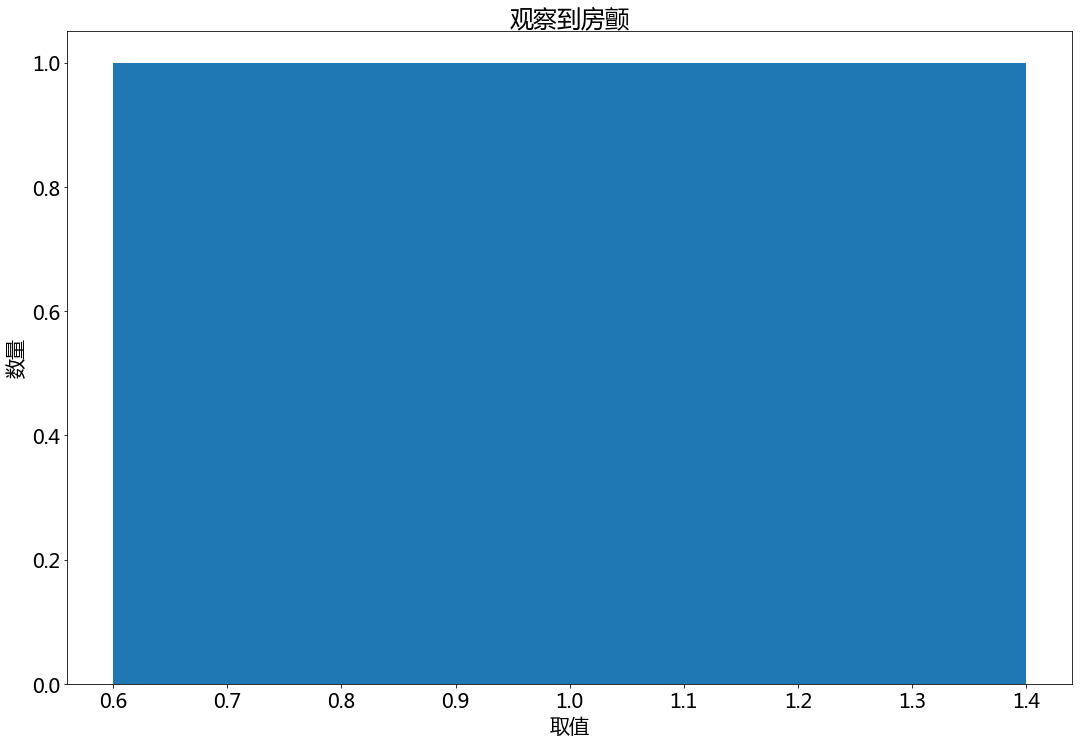

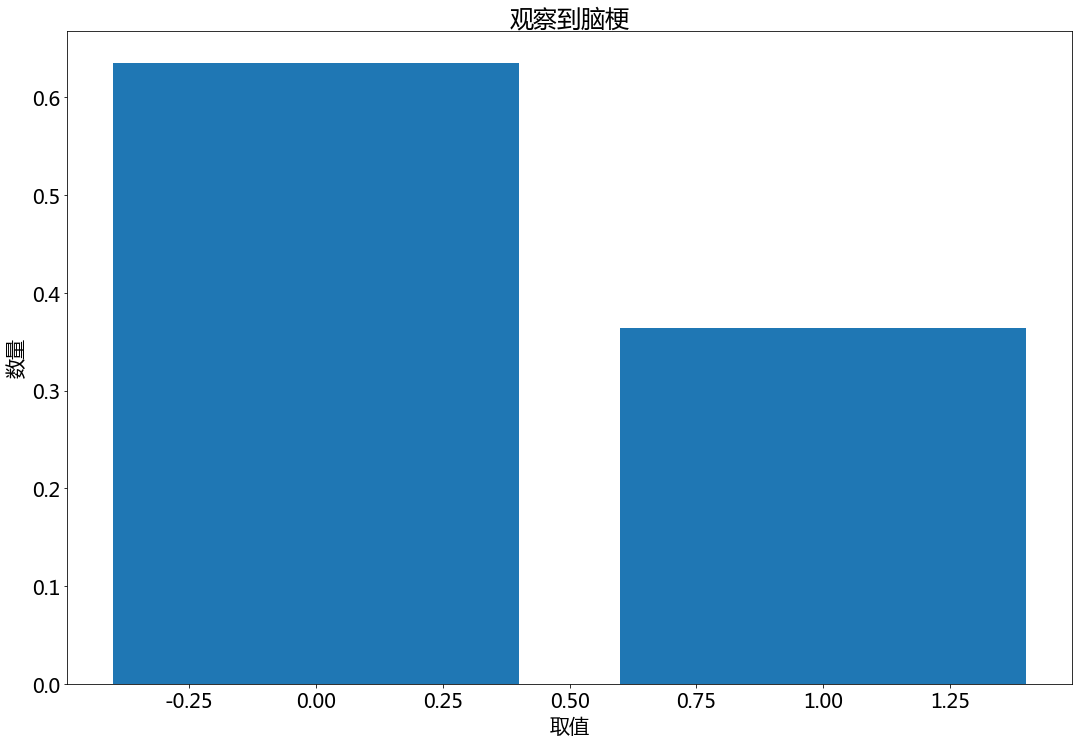

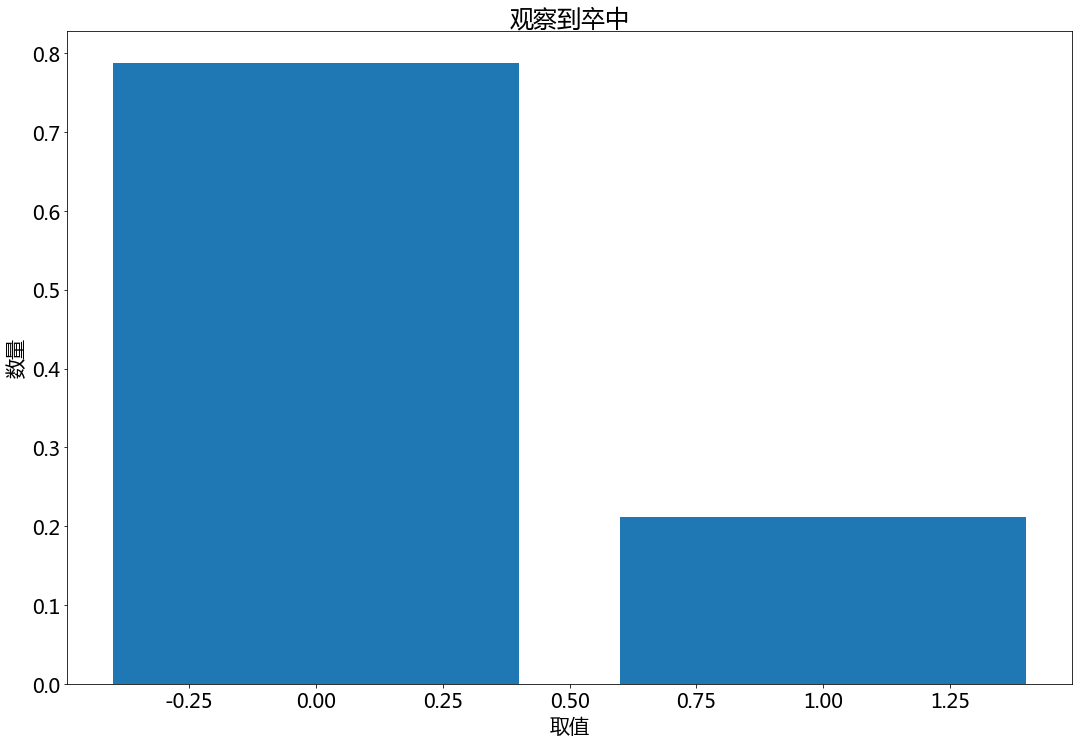

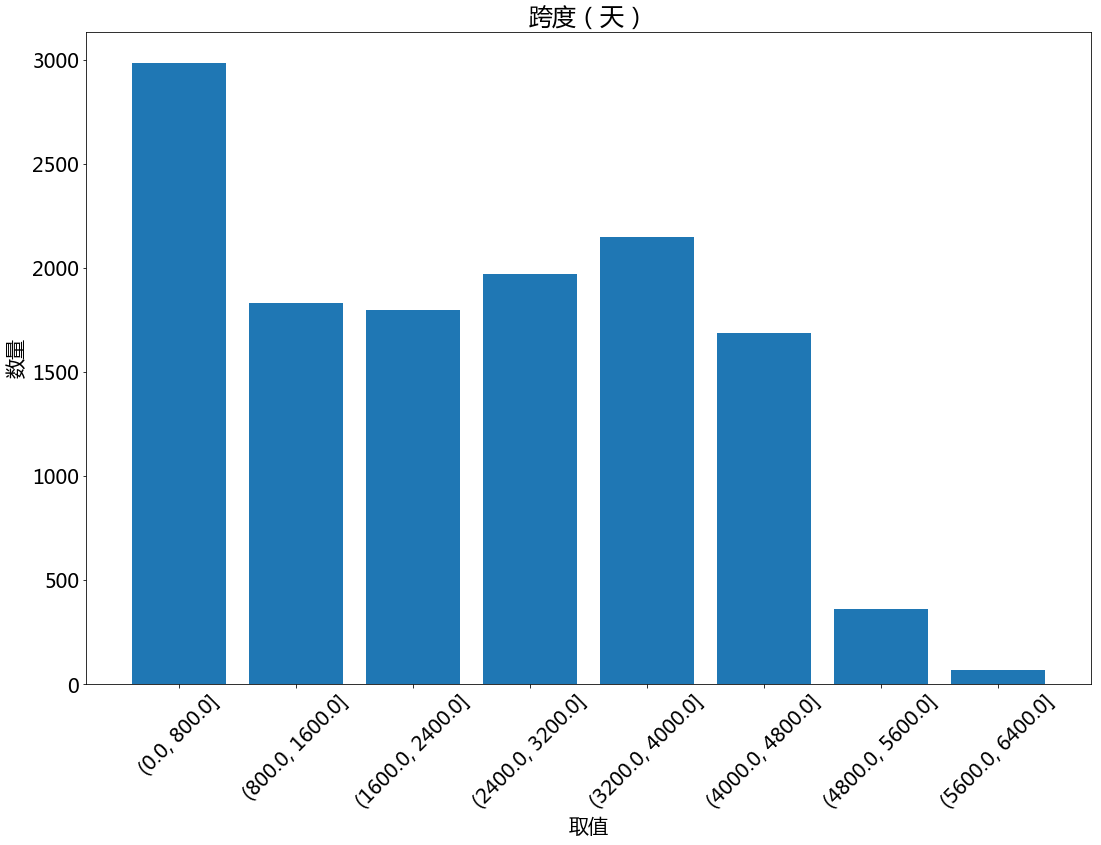

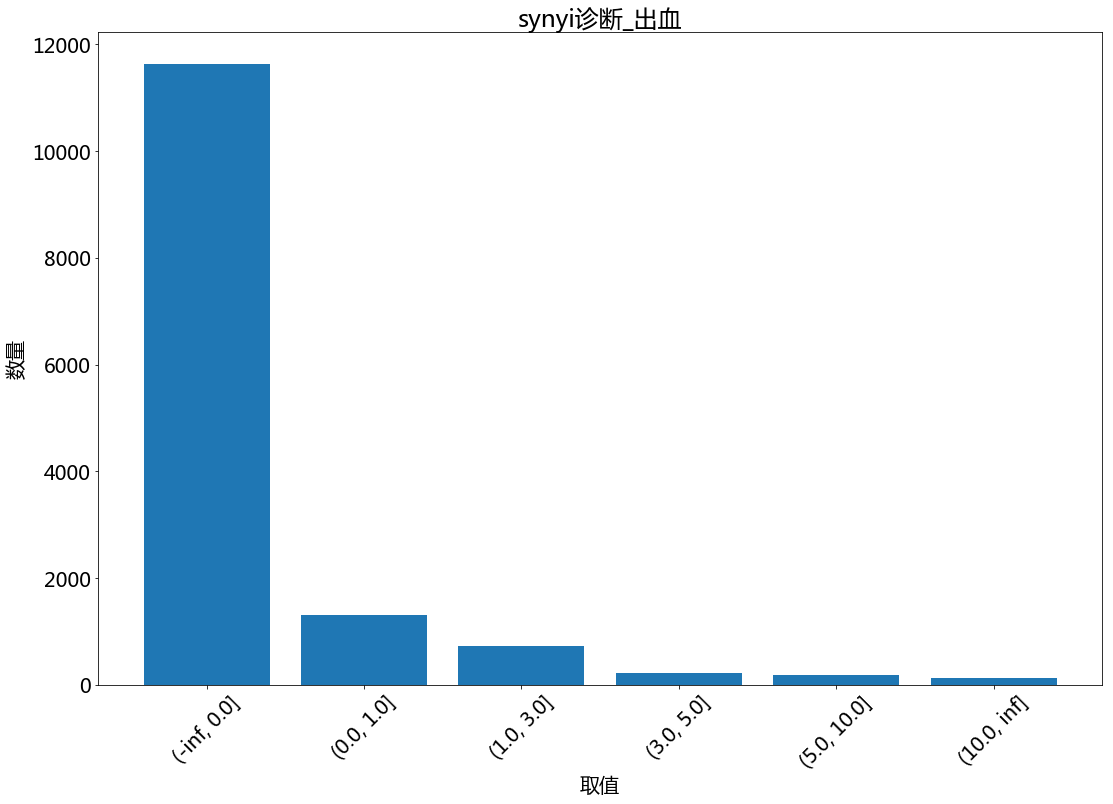

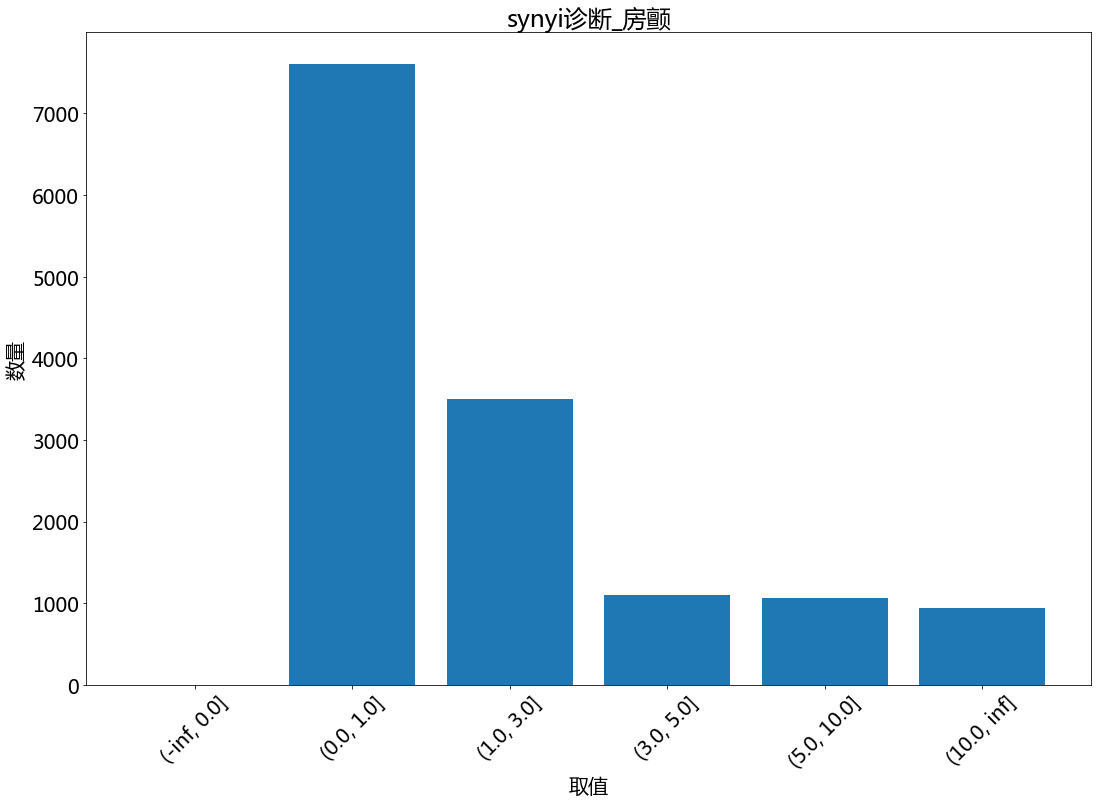

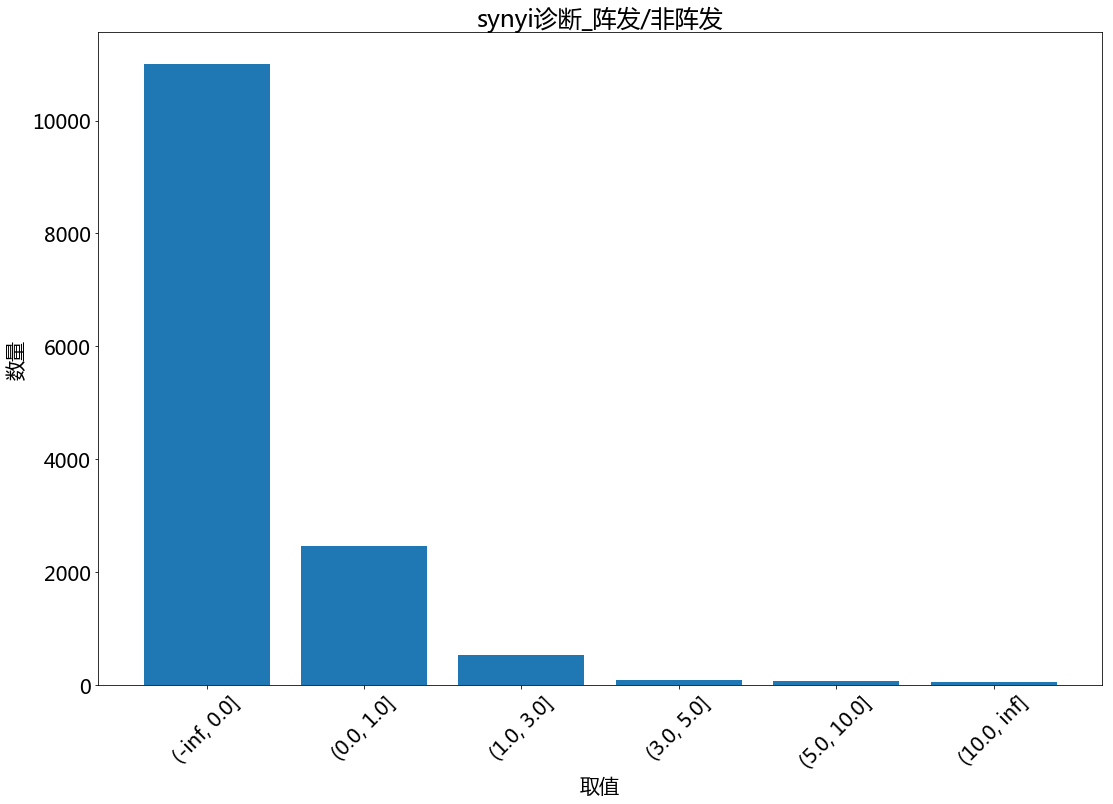

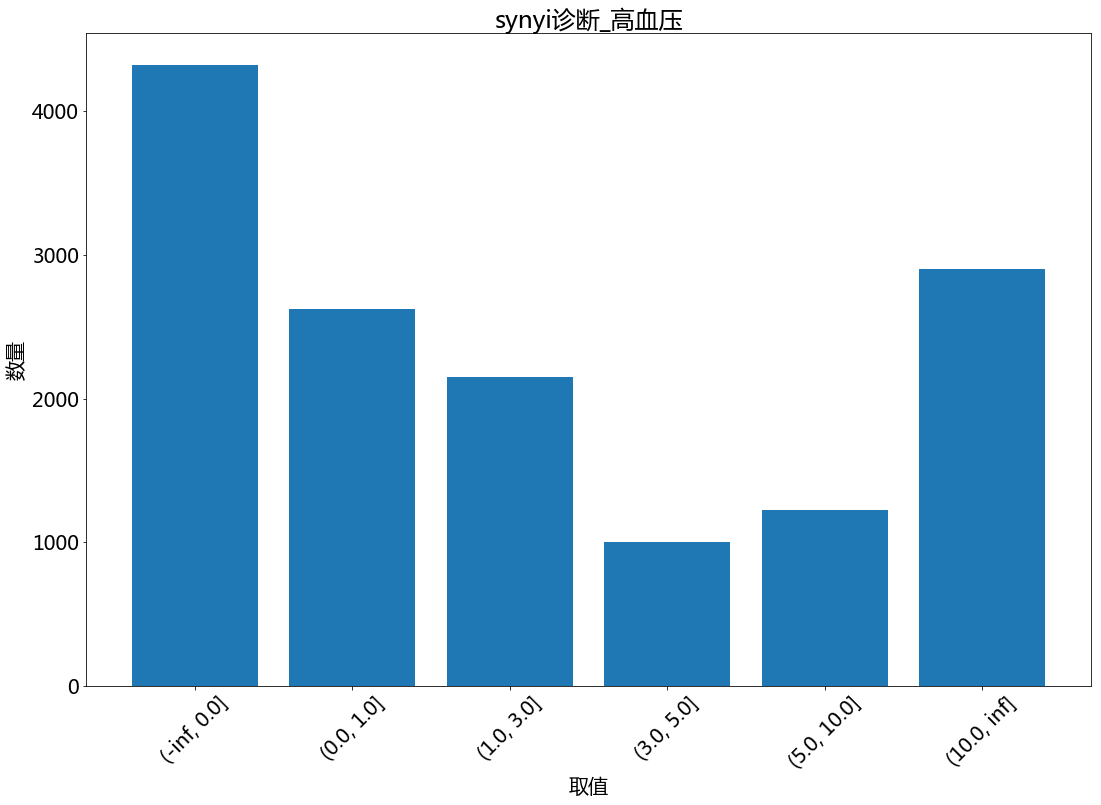

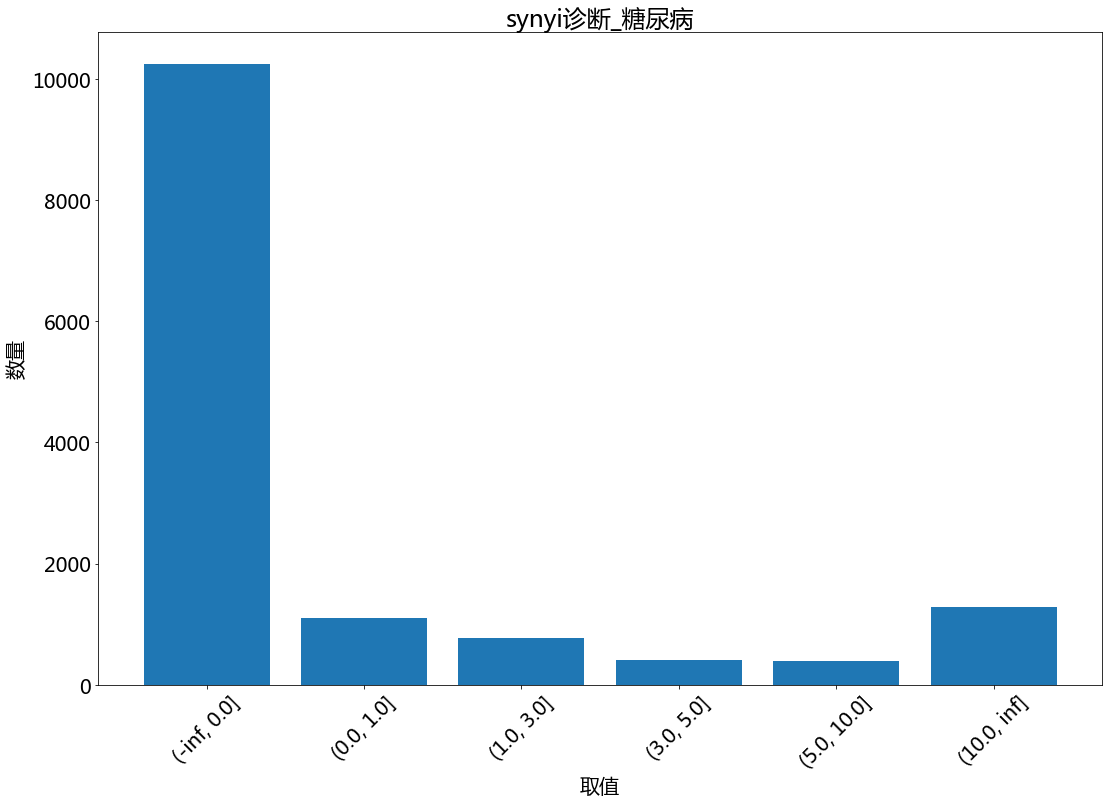

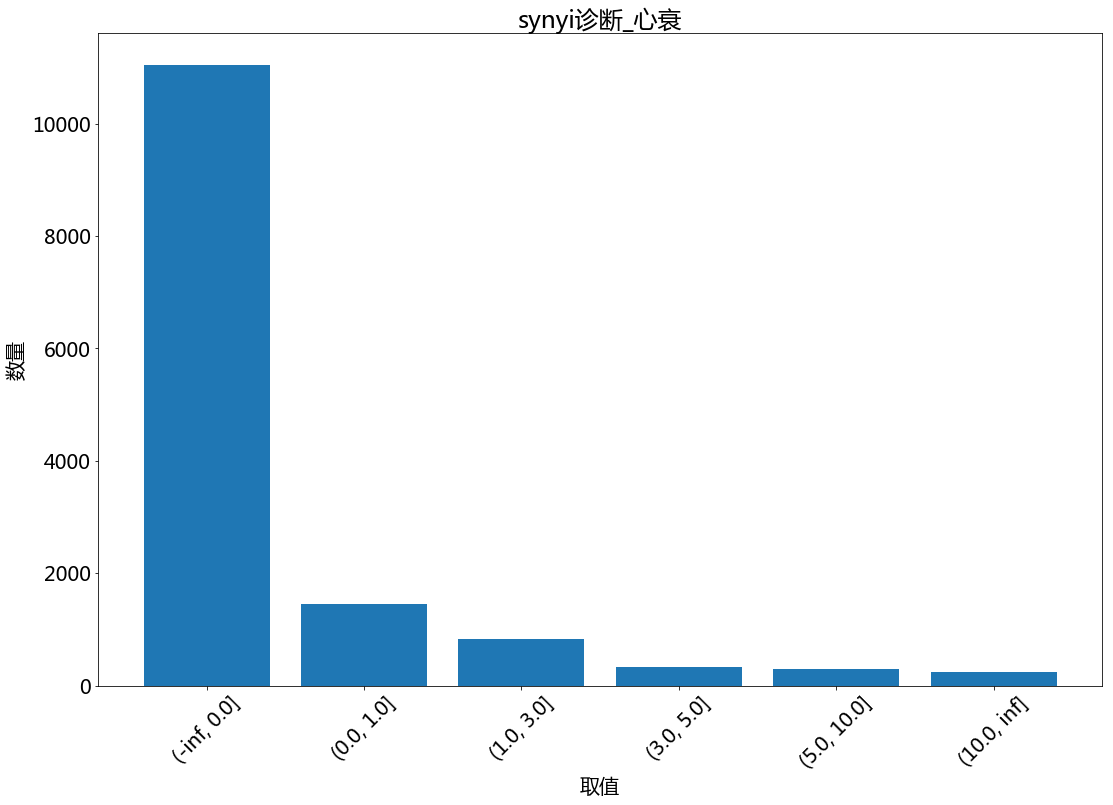

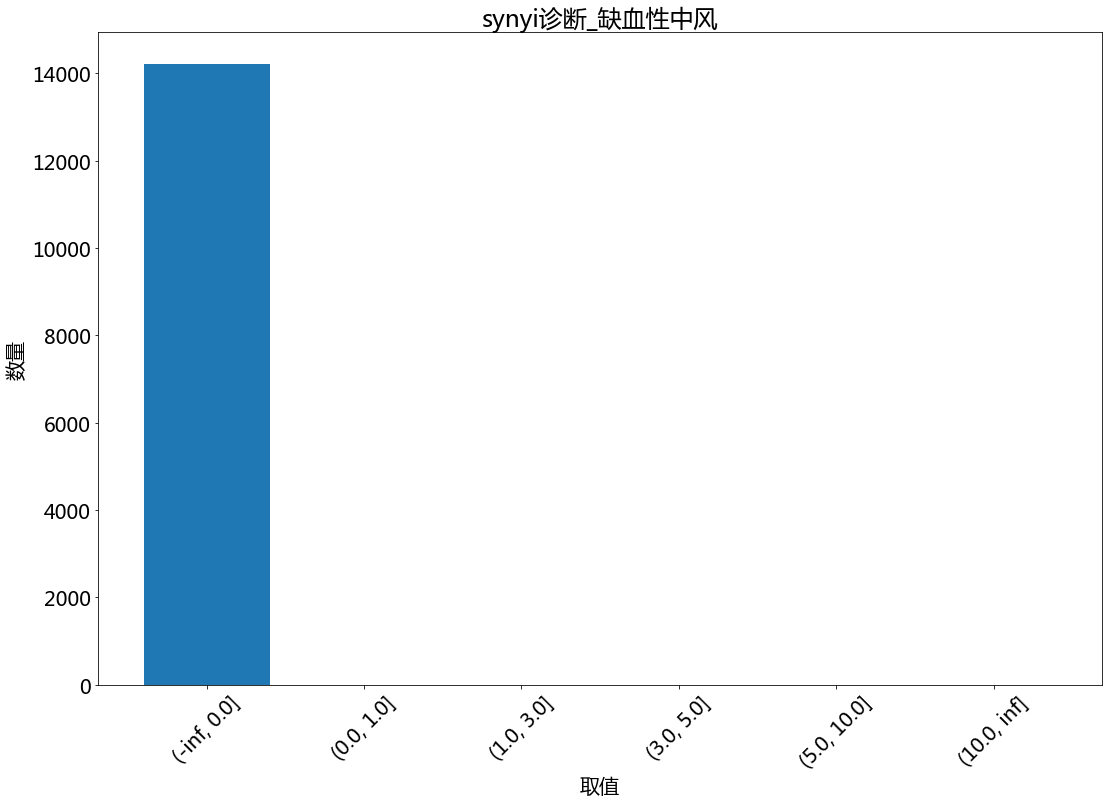

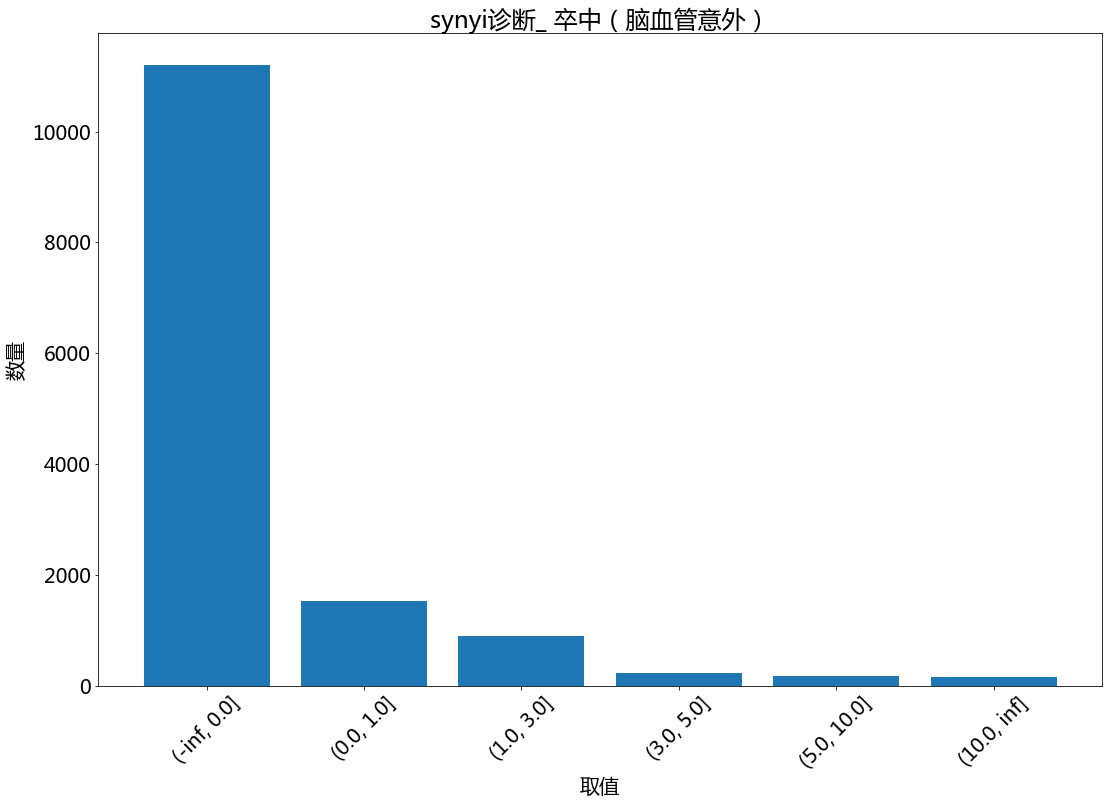

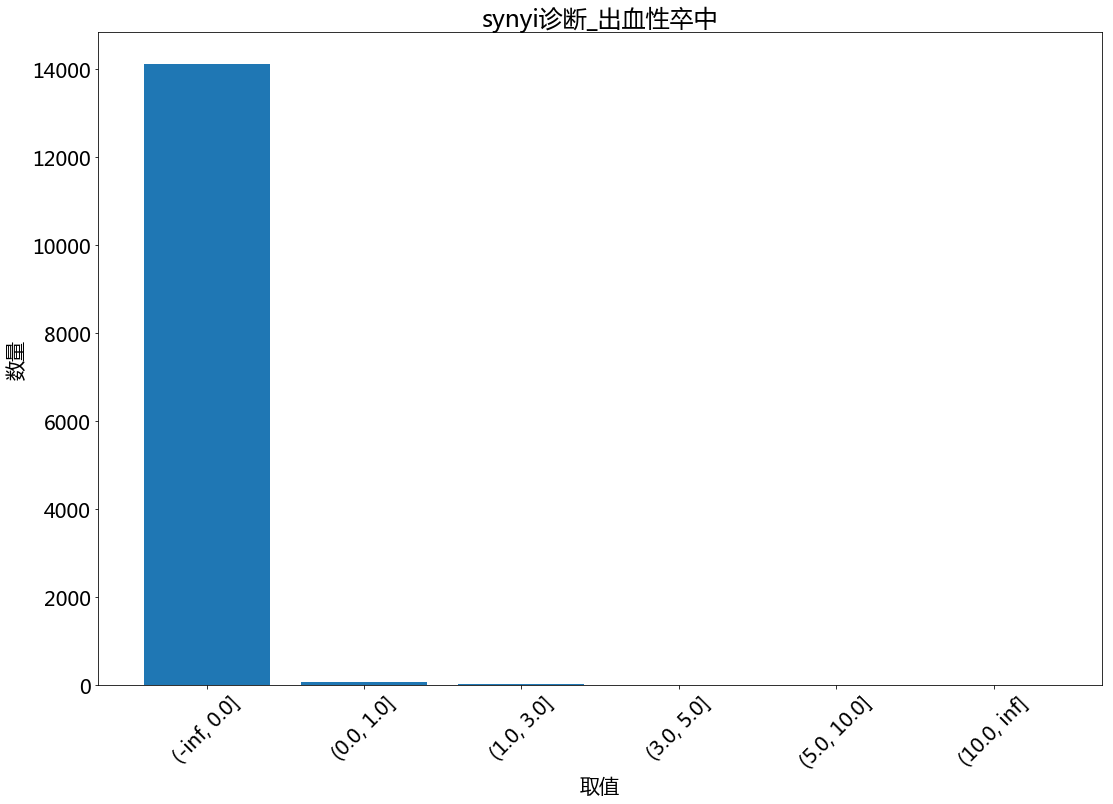

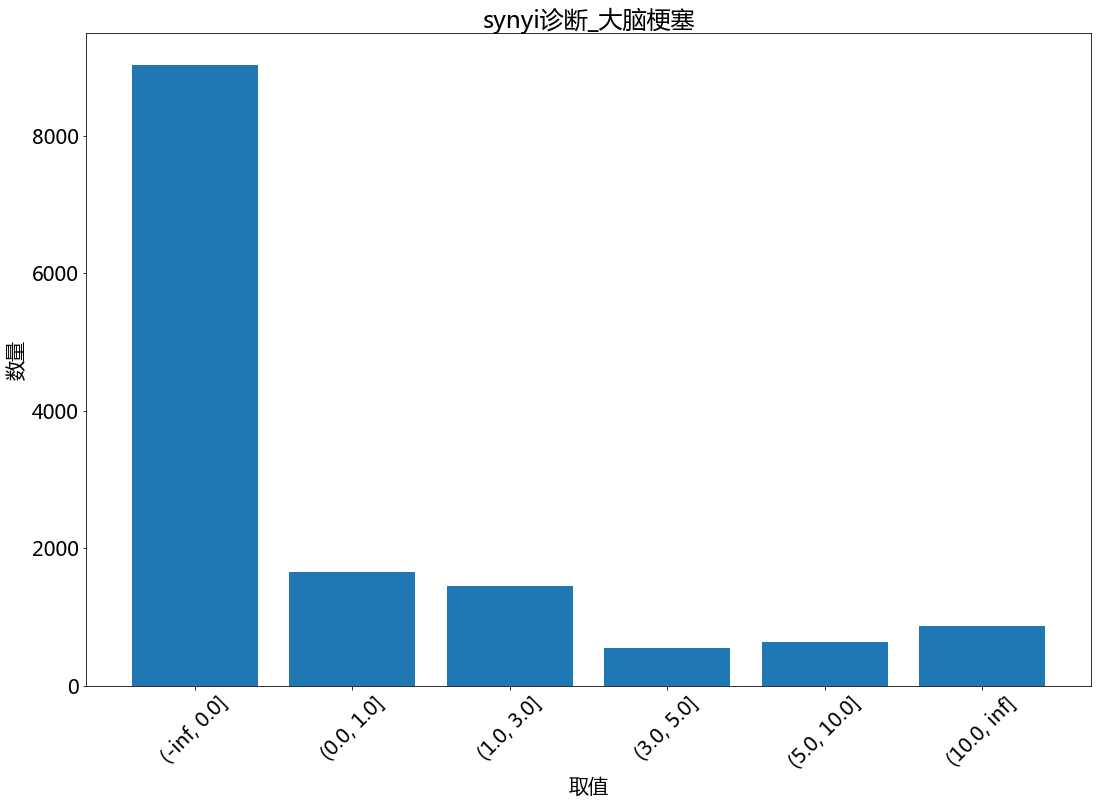

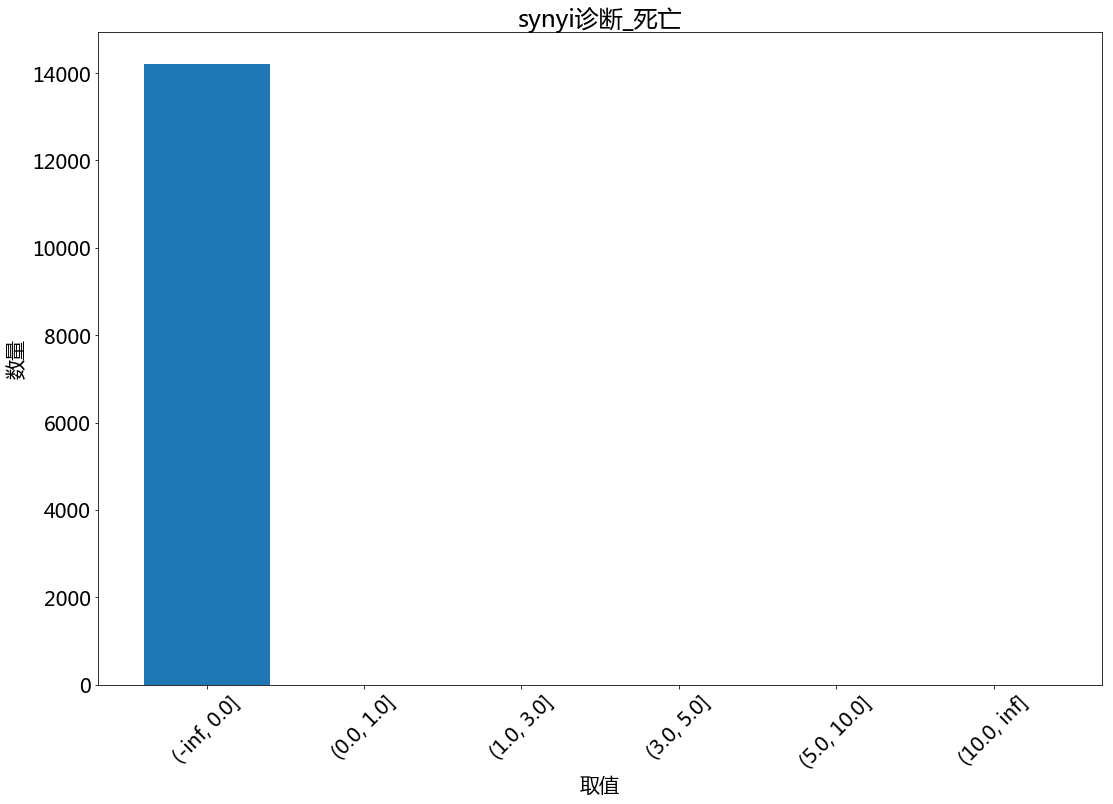

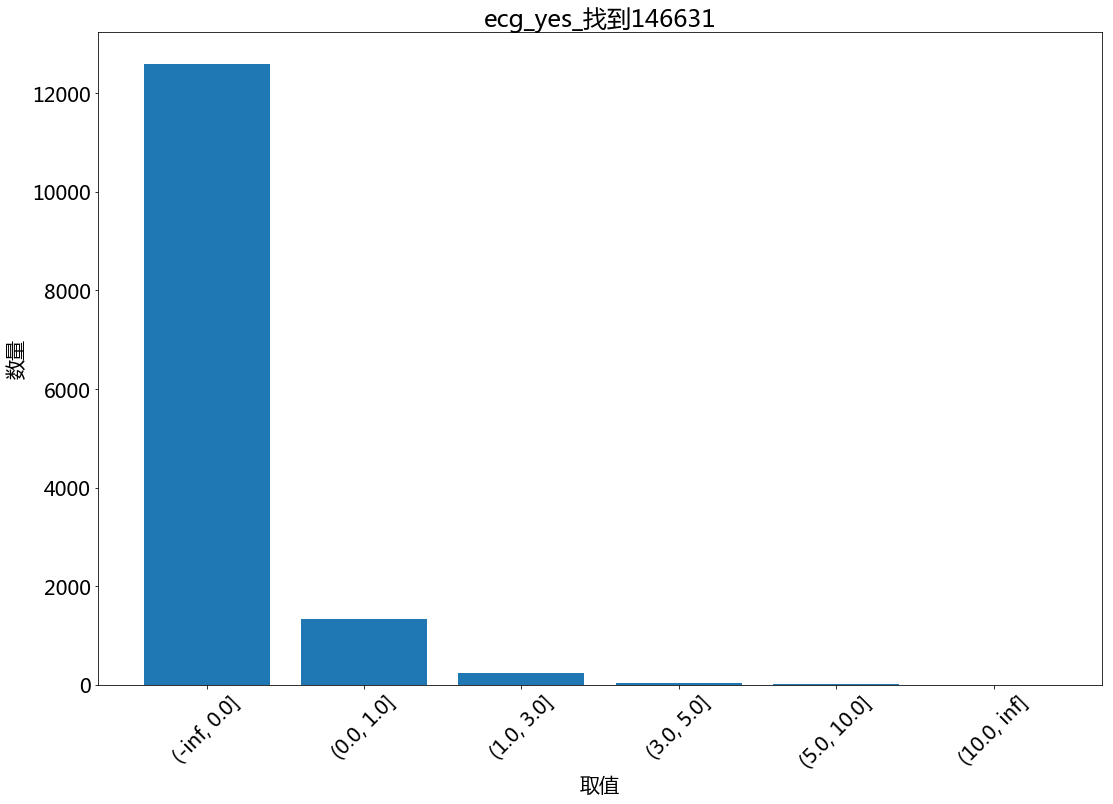

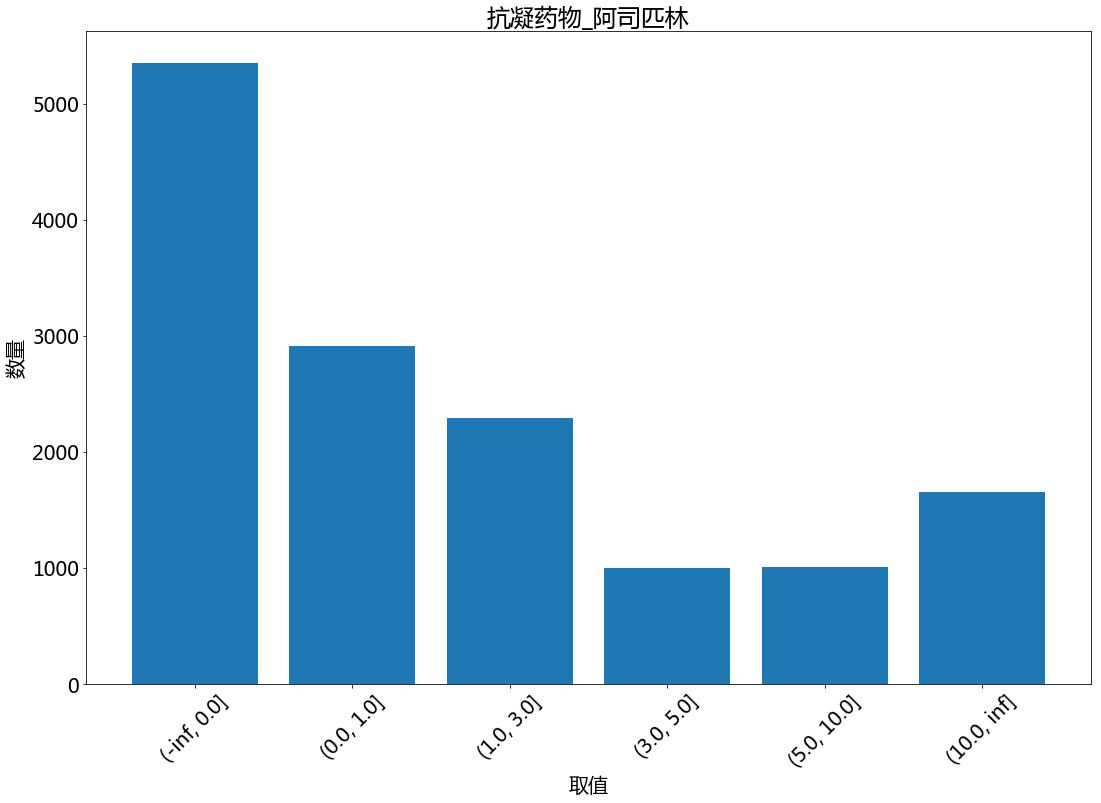

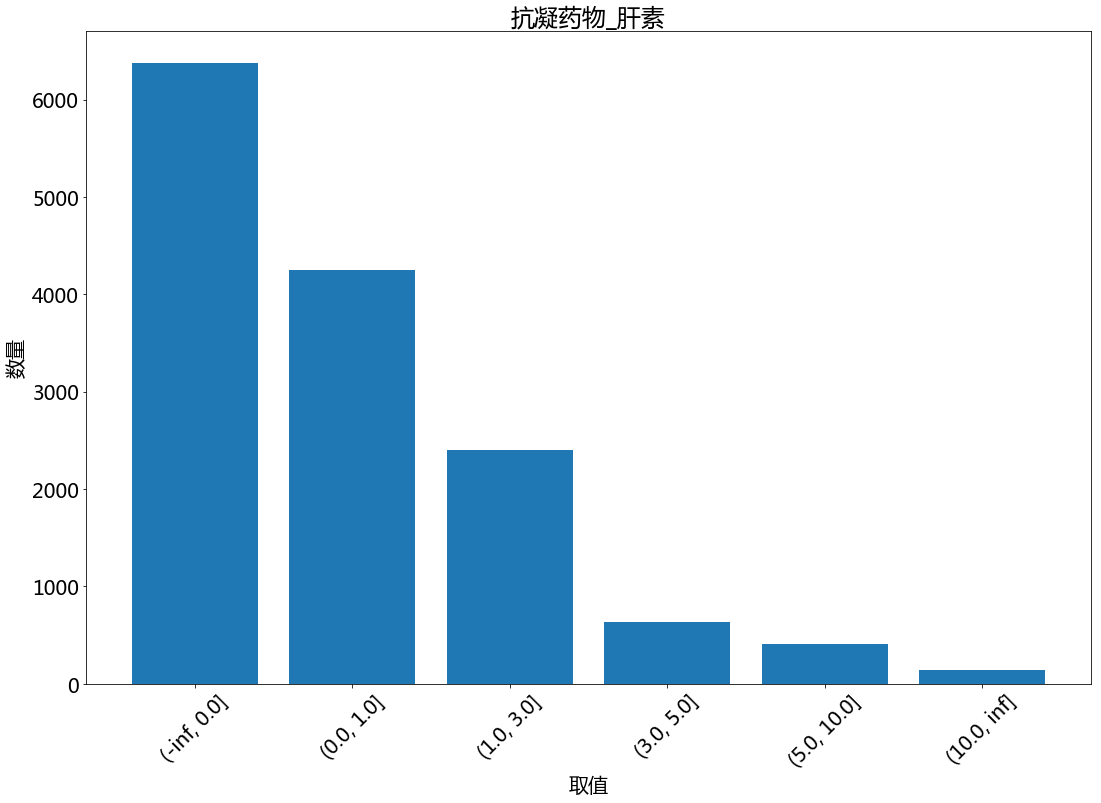

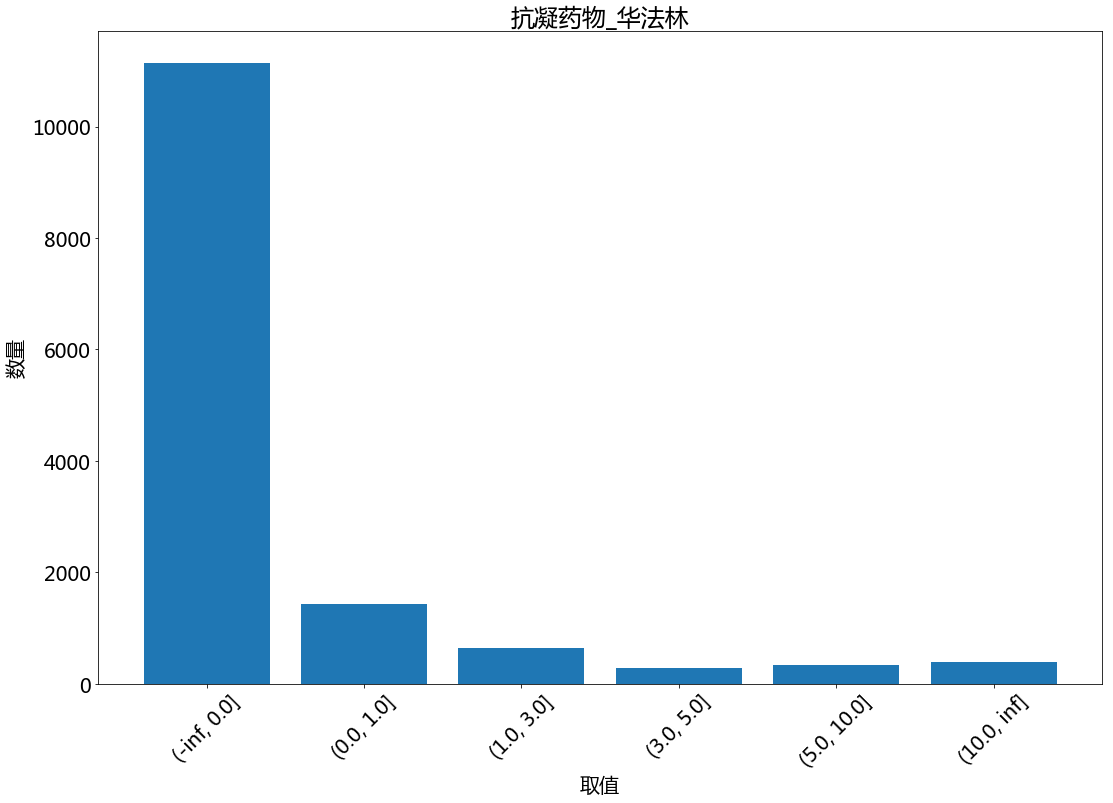

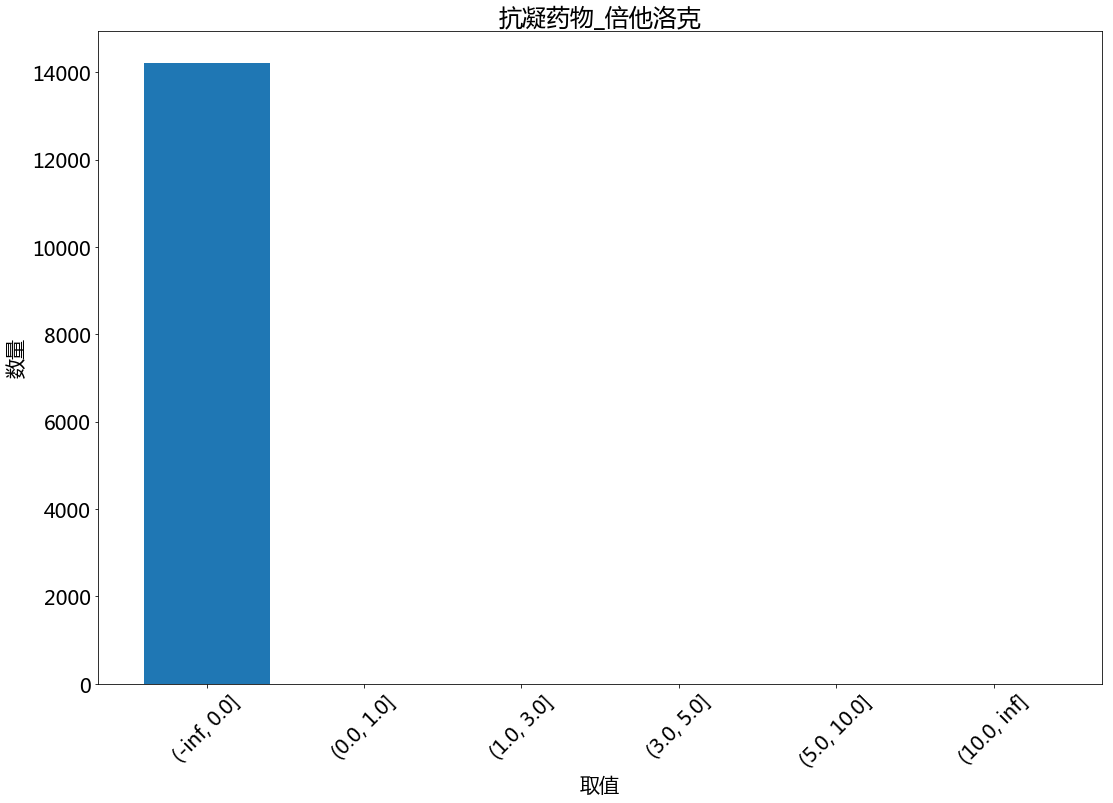

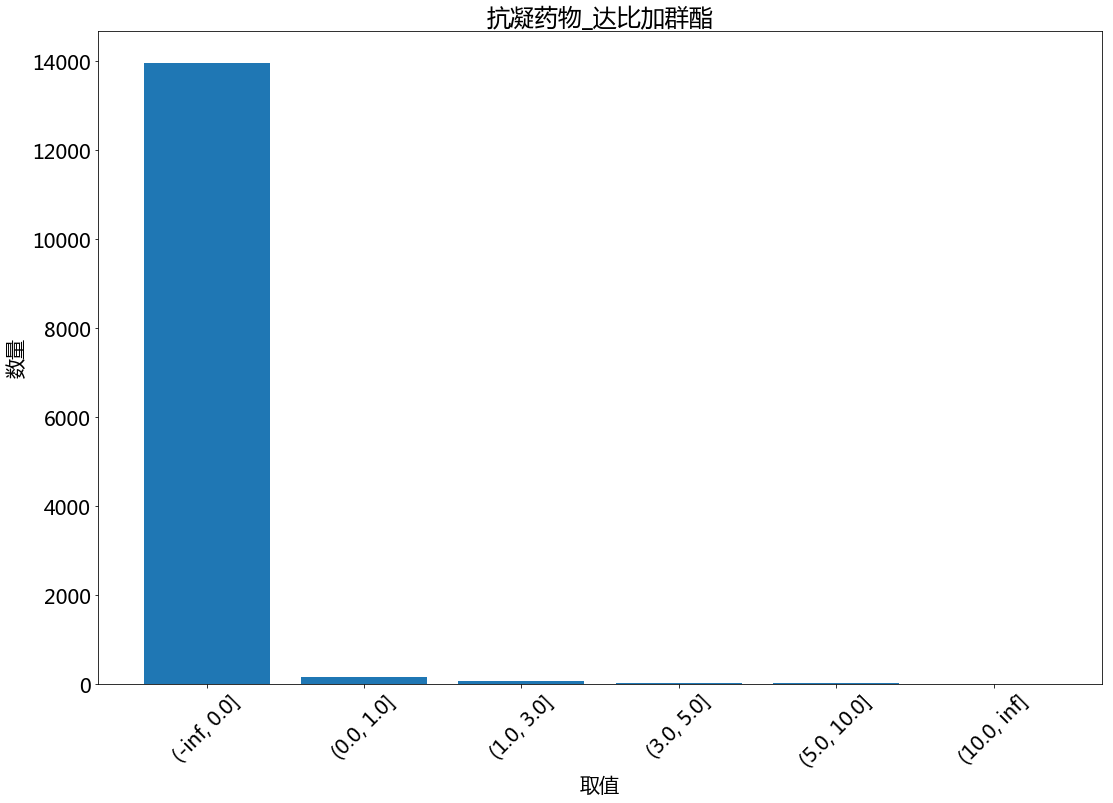

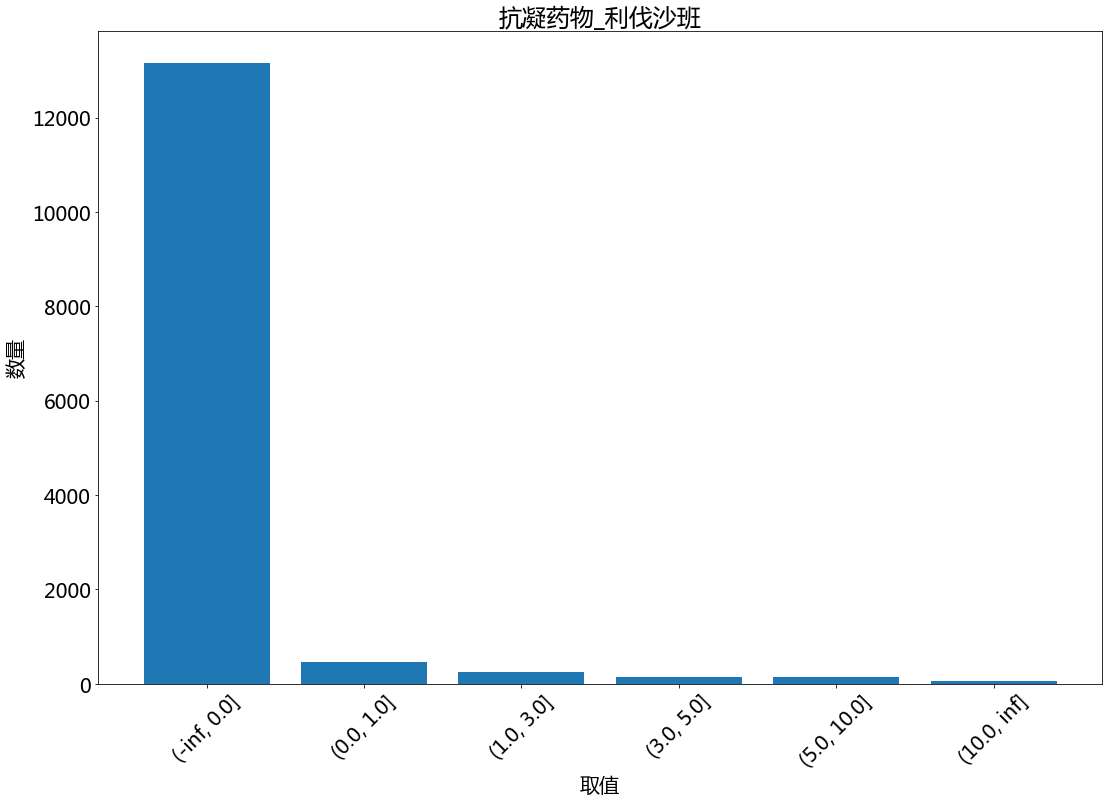

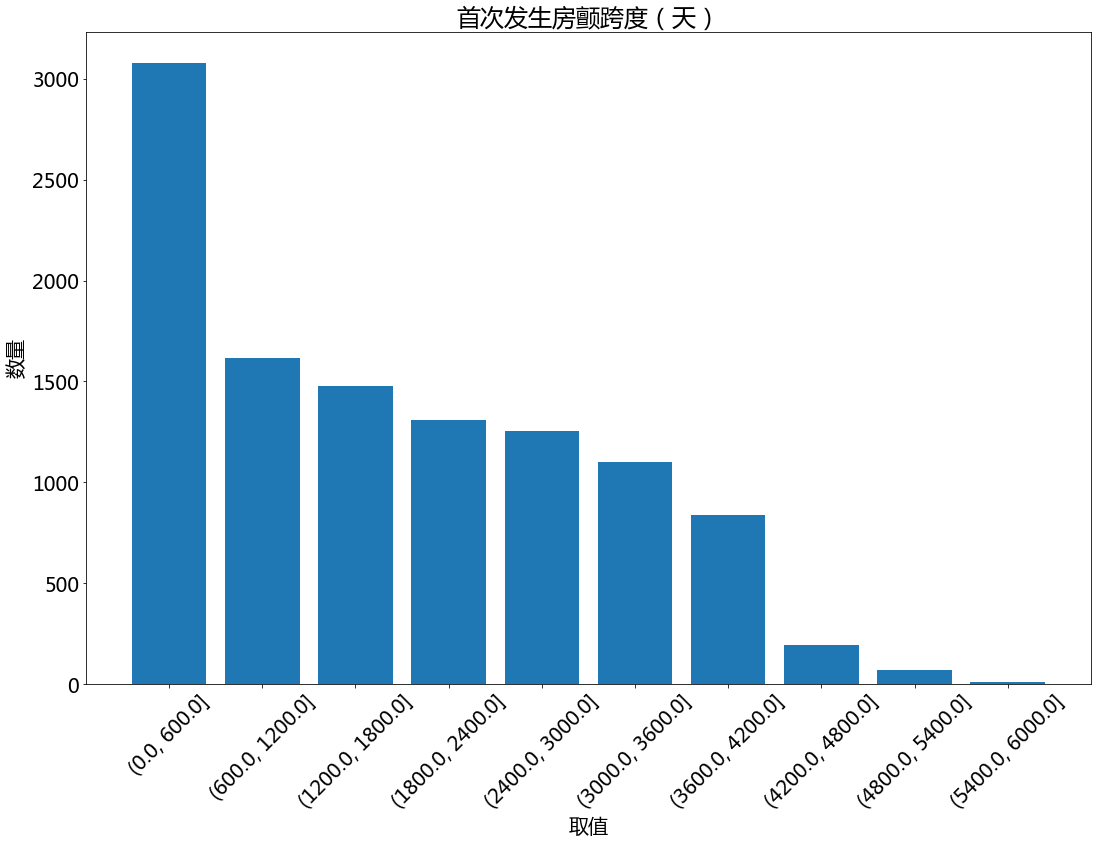

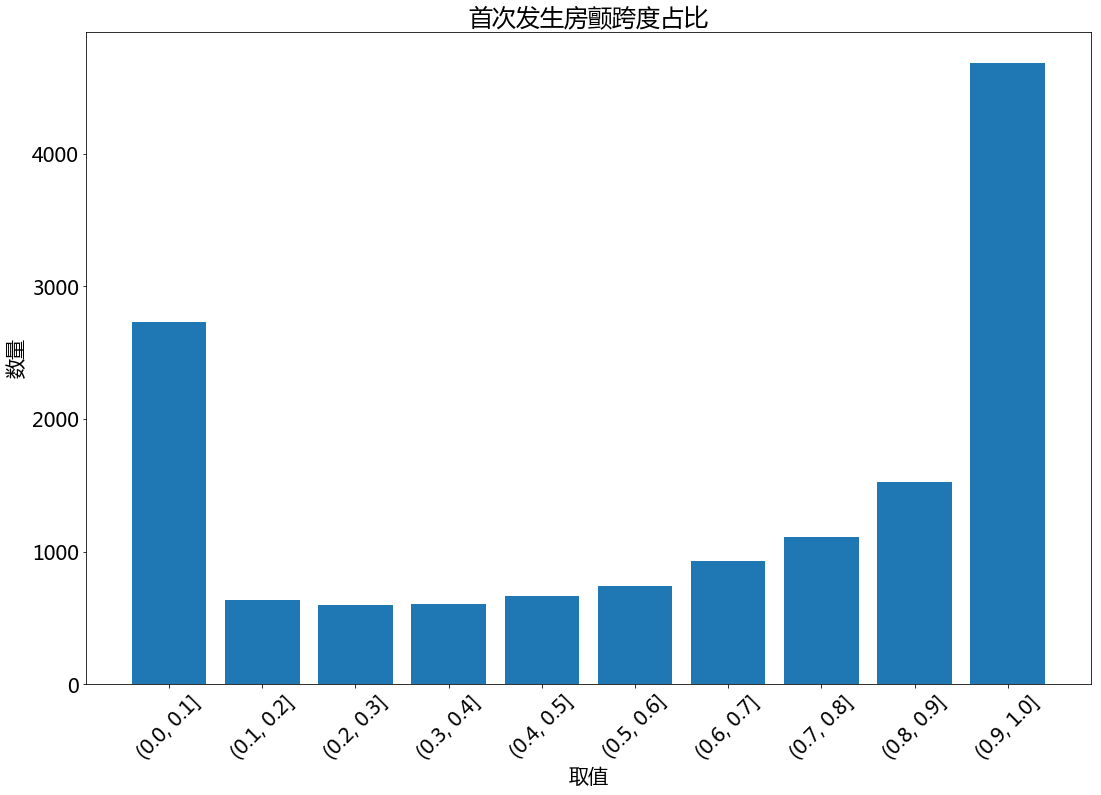

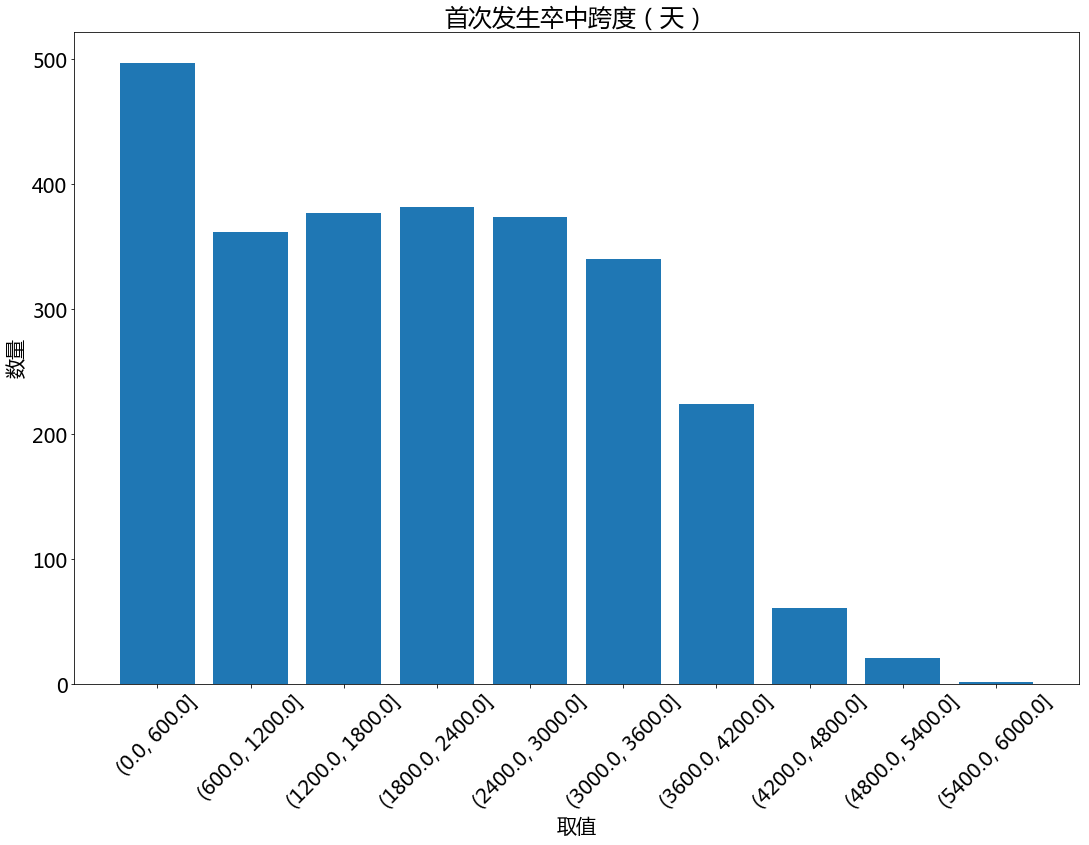

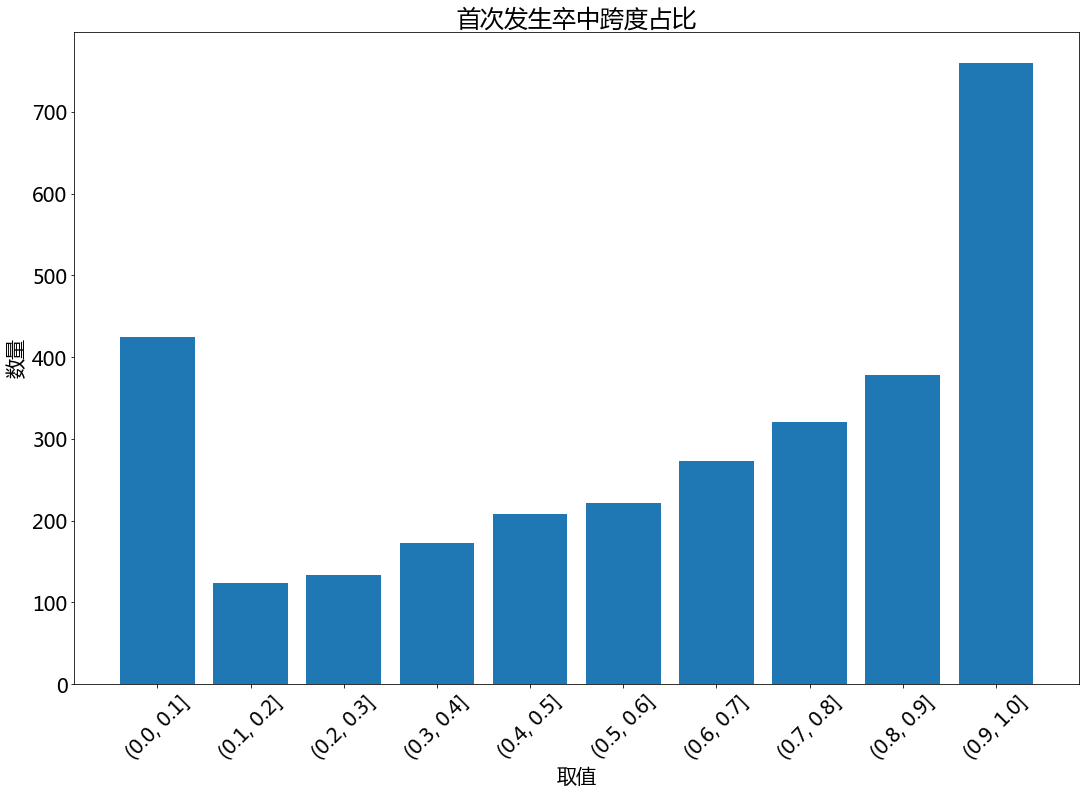

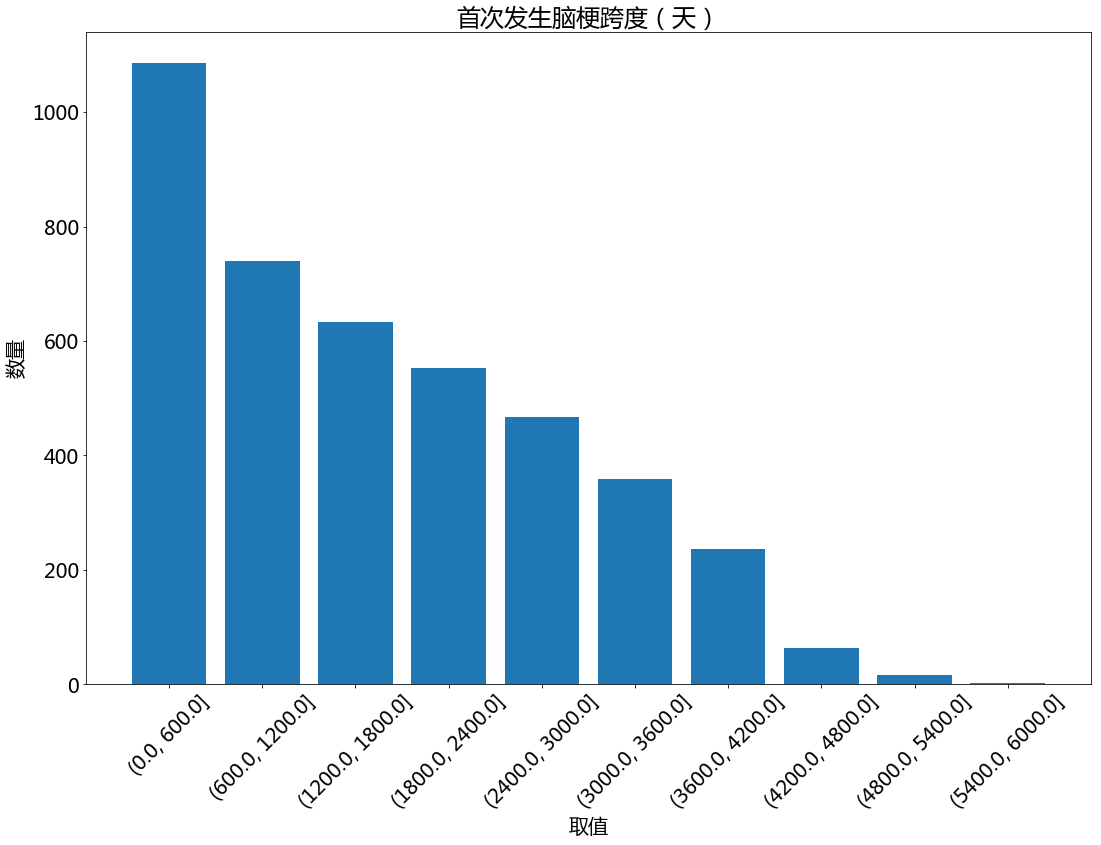

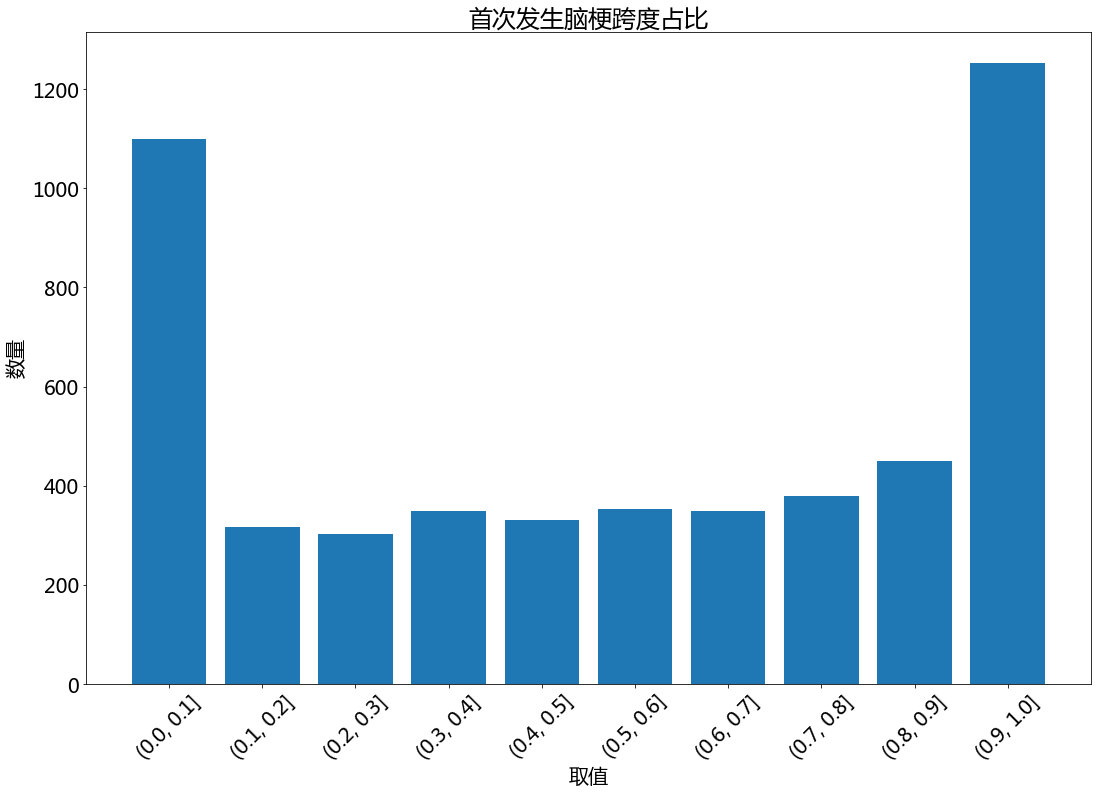

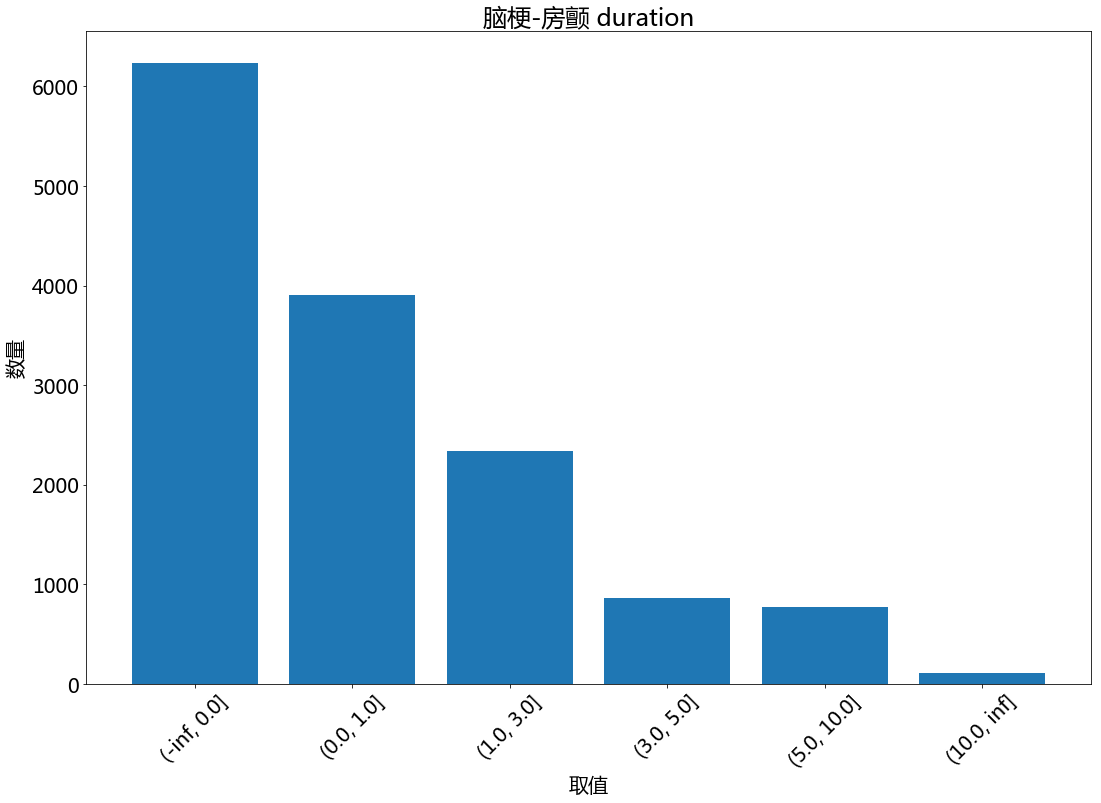

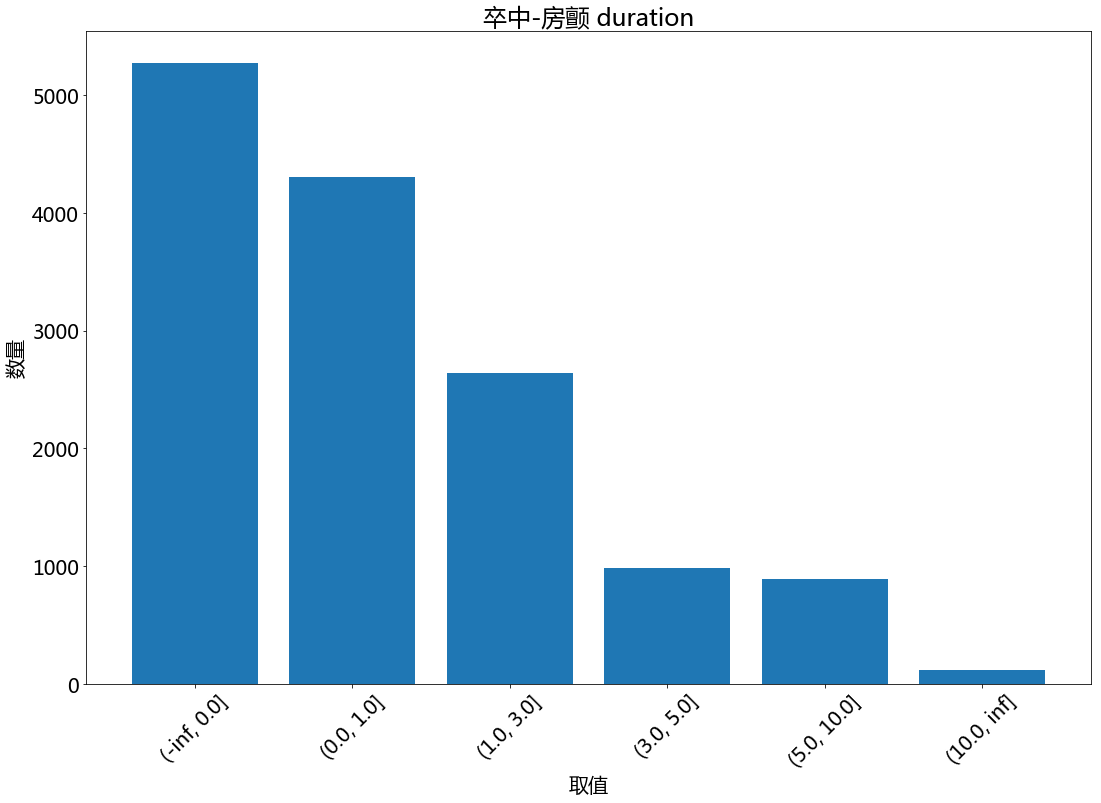

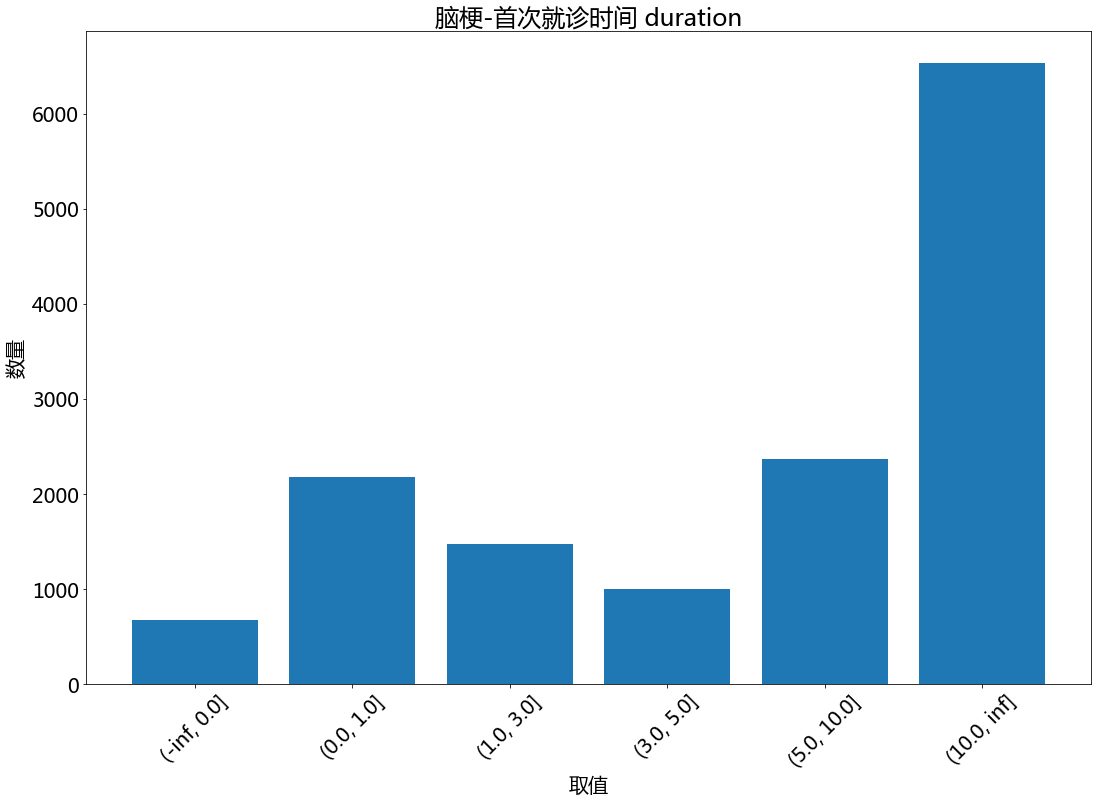

In [33]:
# df = pd.read_csv('train.csv').drop(['Name', 'Ticket', 'Cabin', 'PassengerId'], axis=1)
categorical_df = patient_df.select_dtypes([object, bool])
numerical_df = patient_df.select_dtypes(['number'])

for col in categorical_df:
    s = categorical_df[col].value_counts(dropna=False, normalize=True).sort_index()
    
    
    f, ax = plt.subplots(figsize=[18, 12])
    ax.bar(s.index.fillna('NA'), s)
    ax.set_title(col)
    ax.set_ylabel('数量')
    ax.set_xlabel('取值')
#     ax.set_xticks(s.index, s.values, rotation=45)
    f.savefig(join(output, '{}.png'.format(col.replace('/','或'))))
    
from matplotlib.ticker import MaxNLocator
for col in numerical_df:
    s = numerical_df[col]
    
    f, ax = plt.subplots(figsize=[18, 12])
    if '跨度' in col:
        locator = MaxNLocator(10)
        s = pd.cut(s.values, list(locator.tick_values(s.min(), s.max()))).value_counts()
    else:
        s = pd.cut(s.values, [-infty, 0, 1, 3, 5, 10, infty]).value_counts()

    ax.bar(s.index.astype(str), s)
    ax.set_title(col)
    ax.set_ylabel('数量')
    ax.set_xlabel('取值')
    plt.setp(ax.get_xticklabels(), rotation=45)
    f.savefig(join(output, '{}.png'.format(col.replace('/','或'))))    
    
result_folder = 'result'


# from sunburst import *
# layers = ['治疗类型', '性别', '年龄分组', '心超报告']    
# visualize(df, layers, join(result_folder, 'sunburst.png'))

# 进行配置

In [1]:
import pandas as pd
from distribution_analysis import summarize
from os.path import join

In [2]:
file = 'demo.xlsx'
result_folder = 'result'
layers = ['Sex', 'Pclass', 'Survived', 'Embarked']

# 以下代码不要改

In [61]:
from sunburst import *
import seaborn

df = pd.read_excel(file)
(
    df.groupby(list(df.columns))
    .agg(len)
    .reset_index()
    .rename(columns={0:'n'})
    .to_excel(join(result_folder, 'group_count.xlsx'), index=False)
)
visualize(df, layers, join(result_folder, 'sunburst.png'))

summarize(df, join(result_folder, 'result.xlsx'))

NameError: name 'file' is not defined